In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils.pipeline import \
    PrepInteractionPipeline, PrepMoviePipeline, PrepUserPipeline

In [20]:
data_folder = 'raw_small'

df_users = pd.read_csv(f'./data/{data_folder}/users.csv')
df_items = pd.read_csv(f'./data/{data_folder}/items.csv')
df_inter = pd.read_csv(f'./data/{data_folder}/interactions.csv',
                       parse_dates=['last_watch_dt'], dayfirst=True)

In [21]:
for df_obj, obj_id in zip([df_users, df_items], ['user_id', 'item_id']):
    obj_in_df_obj = set(df_obj[obj_id].values)
    obj_in_df_inter = set(df_inter[obj_id].values)
    obj_to_stay = obj_in_df_obj.intersection(obj_in_df_inter)

    df_obj_mask = df_obj[obj_id].apply(lambda obj: obj in obj_to_stay)
    df_inter_mask = df_inter[obj_id].apply(lambda obj: obj in obj_to_stay)

    df_obj.drop(df_obj[~df_obj_mask].index, inplace=True)
    df_obj.reset_index(drop=True, inplace=True)
    df_inter.drop(df_inter[~df_inter_mask].index, inplace=True)
    df_inter.reset_index(drop=True, inplace=True)

## Train-test split

In [22]:
df_inter.sort_values('last_watch_dt', inplace=True)

train_ratio = 0.8
train_size = int(train_ratio * len(df_inter))
df_train, df_test = df_inter[:train_size].copy(), df_inter[train_size:].copy()

# train users and items for data analysis with no data leakage
train_users = df_train['user_id'].unique()
train_items = df_train['item_id'].unique()
df_users_train = df_users[df_users['user_id'].isin(train_users)].copy()
df_items_train = df_items[df_items['item_id'].isin(train_items)].copy()

df_users_test = df_users[~df_users['user_id'].isin(train_users)].copy()
df_items_test = df_items[~df_items['item_id'].isin(train_items)].copy()

## Samples

In [23]:
df_train.sample(2)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
222809,398518,7417,2021-06-02,1628.0,26.0
214654,946683,14025,2021-04-30,35.0,1.0


In [24]:
df_items_train.sample(2)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
8555,16434,film,Поздняя любовь,Pozdnyaya lubov,2012.0,мелодрамы,Россия,NaN,12.0,NaN,Сергей Алёшечкин,"Евгения Дмитриева, Андрей Егоров, Алёна Конста...",Работница швейной мастерской Лида и ее муж Ант...,"2012, россия, поздняя, любовь"
8859,12379,film,Пять лет и один день,NaN,2012.0,драмы,Россия,NaN,12.0,NaN,Борис Квашнев,"Алина Сергеева, Юрий Батурин, Юлия Галкина, Се...",Мирослава приходит в себя после 5 лет комы и у...,"2012, россия, пять, лет, один, день"


In [25]:
df_users_train.sample(2)

,user_id,age,income,sex,kids_flg
439198,1083802,age_18_24,income_20_40,М,0
253474,63778,age_18_24,income_20_40,М,0


## Interactions

### Overview

The most popular movies

In [26]:
train_views = df_train.groupby('item_id').size().rename('views')

df_items = df_items.merge(pd.DataFrame(train_views).reset_index(), how='left', on='item_id')
df_items['views'] = df_items['views'].fillna(0).astype(int)
df_items = df_items.sort_values('views', ascending=False)

df_items_train = df_items_train.merge(train_views, left_on='item_id', right_index=True).\
    sort_values('views', ignore_index=True, ascending=False)

df_items_train[:10][['title', 'views', 'release_year', 'actors', 'description']]

,title,views,release_year,actors,description
0,Хрустальный,31837,2021.0,"Антон Васильев, Николай Шрайбер, Екатерина Оль...",Сергей Смирнов — один из лучших «охотников на ...
1,Клиника счастья,30157,2021.0,"Дарья Мороз, Анатолий Белый, Данил Акутин, Мар...","Успешный сексолог Алена уверена, что нашла фор..."
2,Гнев человеческий,24371,2021.0,"Джейсон Стэйтем, Холт МакКэллани, Джеффри Доно...",Грузовики лос-анджелесской инкассаторской комп...
3,Девятаев,24350,2021.0,"Павел Прилучный, Павел Чинарёв, Тимофей Трибун...",Военно-исторический блокбастер от режиссёров Т...
4,Секреты семейной жизни,16481,2021.0,"Петр Скворцов, Алена Михайлова, Федор Лавров, ...",У Никиты и Полины всё начиналось прекрасно: об...
5,Прабабушка легкого поведения,14285,2021.0,"Александр Ревва, Глюкоза, Дмитрий Нагиев, Миха...","1980 год, вся страна следит за событиями моско..."
6,Афера,11495,2021.0,"Сергей Степин, Игорь Царегородцев, Татьяна Лял...","Смотри:- как кино- как сериалКарантин окончен,..."
7,Подслушано,10775,2021.0,"Александр Hовиков, Валентина Ляпина, Никита Па...",Смотри:- как кино- как сериалПодростковый псих...
8,Маша,8798,2020.0,"Максим Суханов, Аня Чиповская, Полина Гухман, ...",13-летняя Маша растёт между боксёрским рингом ...
9,Белый снег,7655,2021.0,"Ольга Лерман, Федор Добронравов, Надежда Марки...",Отечественная спортивная драма про лыжницу и о...


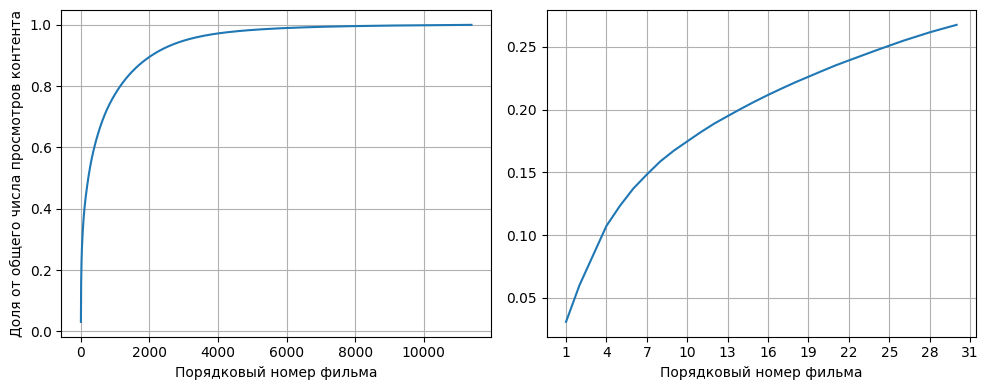

In [9]:
df_views = df_items_train['views']
cumsum = df_views.cumsum()
cumsum = cumsum / cumsum.iloc[-1]
cumsum.index = np.arange(1, len(df_views)+1)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
cumsum.plot(grid=True, ax=ax[0]);
ax[0].set_ylabel('Доля от общего числа просмотров контента')
ax[0].set_xlabel('Порядковый номер фильма')
cumsum[0:30].plot(grid=True, xticks=np.arange(1, 33, step=3), ax=ax[1])
ax[1].set_xlabel('Порядковый номер фильма')
plt.tight_layout()

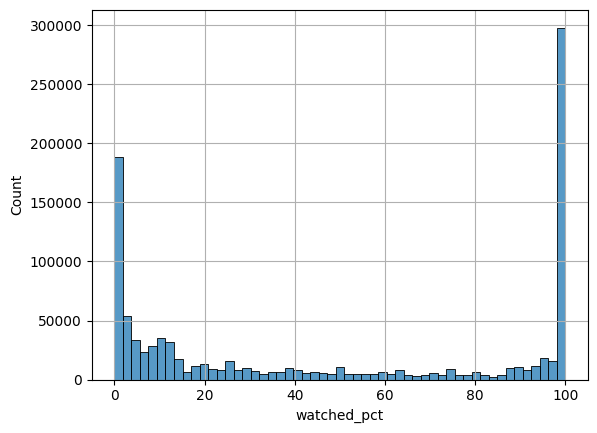

In [10]:
sns.histplot(data=df_train, x='watched_pct')
plt.grid()

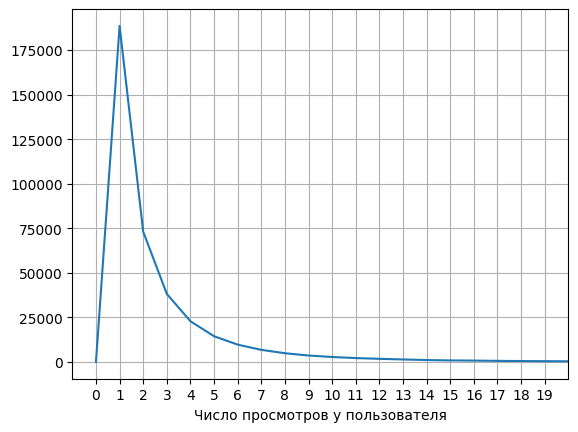

In [11]:
a = df_train.groupby('user_id').size().value_counts()
a[0] = 0
a.sort_index().plot()
plt.xlabel('Число просмотров у пользователя')
plt.xlim([-1, 20]); plt.xticks(range(20))
plt.grid()

### Preparation

In [12]:
df_train.isna().sum()

user_id            0
item_id            0
last_watch_dt      0
total_dur          1
watched_pct      209
dtype: int64

In [13]:
inter_pipe = PrepInteractionPipeline()
inter_pipe.transform(df_train)
inter_pipe.transform(df_test)
inter_pipe.transform(df_inter)

In [14]:
df_train.sample(1)

,user_id,item_id,last_watch_dt,watched_pct
235743,790270,14275,2021-08-03,4.0


In [15]:
df_train.to_csv('./data/processed/interactions_train.csv', index=False)
df_test.to_csv('./data/processed/interactions_test.csv', index=False)
df_inter.to_csv('./data/processed/interactions.csv', index=False)

## Items

### Overview

In [16]:
df_items_train.describe(include='object')

,content_type,title,title_orig,genres,countries,studios,directors,actors,description,keywords
count,11391,11391,8773,11391,11376,704,10578,9721,11390,11016
unique,2,10984,8334,2215,625,35,6337,9515,11163,10976
top,film,Охота,Pet Sematary,документальное,США,HBO,Оливье Шиабоду,Александр Клюквин,МТС «Карантинники» — это домашние акустические...,"2015, чехия, компания, трех"
freq,8787,4,4,613,3219,228,380,18,35,6


In [17]:
df_items_train['content_type'].value_counts()

content_type
film      8787
series    2604
Name: count, dtype: int64

In [18]:
df_items_train['age_rating'].value_counts().sort_index()

age_rating
0.0      978
6.0      999
12.0    2783
16.0    4169
18.0    2025
21.0     437
Name: count, dtype: int64

In [19]:
df_items_train['genres'].value_counts()

genres
документальное                                                                       613
драмы                                                                                580
комедии                                                                              461
для взрослых                                                                         437
мелодрамы, комедии                                                                   226
                                                                                    ... 
русские мультфильмы, русские, для детей, комедии                                       1
криминал, детективы, драмы, триллеры, фантастика                                       1
для детей, полнометражные, приключения, зарубежные, семейное                           1
для детей, приключения, полнометражные, зарубежные, фэнтези, западные мультфильмы      1
биография, драмы, зарубежные, исторические, мелодрамы                                  1
Name: count, L

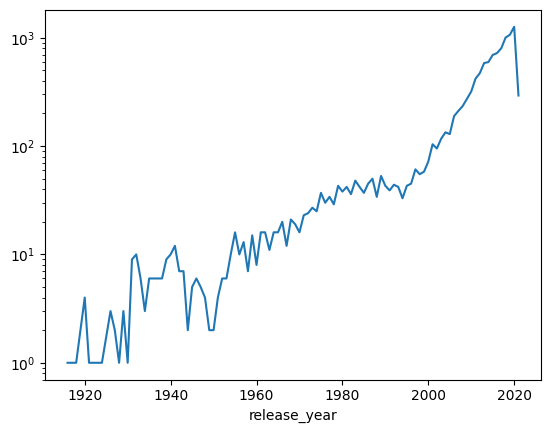

In [20]:
df_items_train['release_year'].value_counts().sort_index().plot(logy=True);

In [21]:
listoflists = df_items_train['keywords'].apply(lambda line: str(line).split(', '))
keywords = [word for line in listoflists for word in line]
pd.Series(keywords).value_counts().head(10)

отношения            5170
соединенные штаты    2529
Россия               1950
женщины              1529
любовь               1469
США                  1446
борьба               1310
мужчины              1277
2020                 1227
преодоление          1203
Name: count, dtype: int64

In [22]:
df_items_train.sample(1)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,views
9417,12886,series,Два силуэта на закате солнца,NaN,2020.0,"русские, детективы",Россия,NaN,16.0,NaN,Александра Бутько,"Александр Пашков, Александра Бутько, Алиса Вар...","Талантливая фотограф Инга неожиданно узнаёт, ч...","Два, силуэта, закате, солнца, 2020, Россия, лю...",1


### Preparation

In [23]:
df_items_train.isnull().sum()

item_id             0
content_type        0
title               0
title_orig       2618
release_year       45
genres              0
countries          15
for_kids        10870
age_rating          0
studios         10687
directors         813
actors           1670
description         1
keywords          375
views               0
dtype: int64

In [24]:
movie_pipe = PrepMoviePipeline(keyword_features_count=200)
X_movies_train = movie_pipe.fit_transform(df_items_train)
X_movies_test = movie_pipe.transform(df_items_test)
X_movies = movie_pipe.transform(df_items)

In [25]:
df_items_train.sample(1)

,item_id,content_type,title,genres,age_rating,description,keywords,views
9353,6456,series,Ищите женщину,"русские, криминал, комедии",0,"Детективная история, которая полна неожиданных...","Ищите, женщину, 1983, СССР",1


In [26]:
df_items_train.to_csv('./data/processed/items_train.csv', index=False)
df_items_test.to_csv('./data/processed/items_test.csv', index=False)
df_items.to_csv('./data/processed/items.csv', index=False)

## Users overview

### Overview

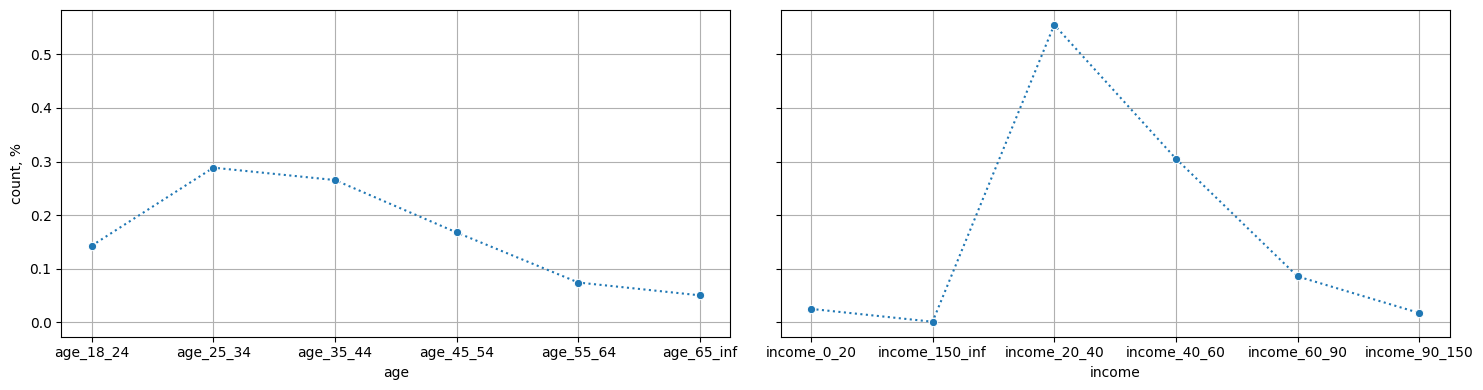

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4), sharey=True)
sns.lineplot(df_users_train['age'].value_counts().sort_index()/len(df_users_train),
             linestyle='dotted', marker='o', ax=ax[0])
sns.lineplot(df_users_train['income'].value_counts().sort_index()/len(df_users_train),
             linestyle='dotted', marker='o', ax=ax[1])
ax[0].set_ylabel('count, %')
ax[0].grid(); ax[1].grid(); plt.tight_layout()

In [28]:
df_users_train.describe(include='object')

,age,income,sex
count,373331,373533,372869
unique,6,6,2
top,age_25_34,income_20_40,Ж
freq,108843,209294,189304


In [29]:
df_users_train['kids_flg'].value_counts(normalize=True)

kids_flg
0    0.676182
1    0.323818
Name: proportion, dtype: float64

### Preparation

In [30]:
user_pipe = PrepUserPipeline()
X_users_train = user_pipe.fit_transform(df_users_train)
X_users_test = user_pipe.transform(df_users_test)
X_users = user_pipe.transform(df_users)

In [31]:
df_users_train.to_csv('./data/processed/users_train.csv', index=False)
df_users_test.to_csv('./data/processed/users_test.csv', index=False)
df_users.to_csv('./data/processed/users.csv', index=False)

In [32]:
np.savez_compressed('./data/processed/encoded_data_train',
                    X_users_train=X_users_train.astype(np.float32),
                    X_movies_train=X_movies_train.astype(np.float32))

np.savez_compressed('./data/processed/encoded_data_test',
                    X_users_test=X_users_test.astype(np.float32),
                    X_movies_test=X_movies_test.astype(np.float32))

np.savez_compressed('./data/processed/encoded_data',
                    X_users=X_users.astype(np.float32),
                    X_movies=X_movies.astype(np.float32))